In [11]:
import numpy as np
import pandas as pd

In [12]:
get_price('000001.XSHE',start_date='2017-01-01',end_date='2017-01-06')

,total_turnover,open,limit_up,limit_down,high,num_trades,volume,low,close
2017-01-03,4.205952e+08,8.7442,9.6081,7.8612,8.8114,13730.0,45984049.0,8.7250,8.7922
2017-01-04,4.115034e+08,8.7826,9.6753,7.9092,8.8114,11850.0,44932953.0,8.7730,8.7922
2017-01-05,3.157697e+08,8.8018,9.6753,7.9092,8.8114,11764.0,34437291.0,8.7826,8.8018
2017-01-06,3.271764e+08,8.8018,9.6849,7.9187,8.8018,14671.0,35815420.0,8.7442,8.7634


In [13]:
#pandas里的panel结构
get_price(['000001.XSHE','000002.XSHE'],start_date='2017-01-01',end_date='2017-01-07',fields='close')

,000001.XSHE,000002.XSHE
2017-01-03,8.7922,19.2937
2017-01-04,8.7922,19.4054
2017-01-05,8.8018,19.4798
2017-01-06,8.7634,19.2099


In [14]:
#获得交易日
get_trading_dates(start_date='2019-01-01', end_date='2019-01-09', market='cn')

[datetime.date(2019, 1, 2),
 datetime.date(2019, 1, 3),
 datetime.date(2019, 1, 4),
 datetime.date(2019, 1, 7),
 datetime.date(2019, 1, 8),
 datetime.date(2019, 1, 9)]

In [15]:
#获取财务数据
q = query(fundamentals.income_statement.revenue,
         fundamentals.income_statement.cost_of_goods_sold,
          fundamentals.eod_derivative_indicator.pe_ratio
         )

fund = get_fundamentals(q,entry_date='2018-01-02')

/usr/local/lib/python3.6/site-packages/rqdatac/services/financial.py:339: UserWarning: Panel will be deprecated. Please use 'expect_df=True' to get a MultiIndex DataFrame.
  warnings.warn("Panel will be deprecated. Please use 'expect_df=True' to get a MultiIndex DataFrame.")


In [16]:
fund.minor_xs('000001.XSHE')

,revenue,cost_of_goods_sold,pe_ratio
2018-01-02,7.9832e+10,NaN,10.1442


In [17]:
from scipy.stats.mstats import winsorize

pe_ratio = get_fundamentals(query(fundamentals.eod_derivative_indicator.pe_ratio),entry_date='20180102')['pe_ratio']

print(type(pe_ratio))
print(pe_ratio)

<class 'pandas.core.frame.DataFrame'>
           600054.XSHG 600316.XSHG 000570.XSHE 000892.XSHE 000715.XSHE  \
2018-01-02     25.9351      334.01       68.19     18.2915     31.6029   

           002099.XSHE 600685.XSHG 002441.XSHE 002197.XSHE 300101.XSHE  ...  \
2018-01-02     27.1992    -746.107     27.2347     149.542     242.137  ...   

           002416.XSHE 002183.XSHE 002182.XSHE 002075.XSHE 603042.XSHG  \
2018-01-02     25.8615     25.7119     39.8738     50.4726     55.3581   

           002184.XSHE 002074.XSHE 600977.XSHG 002893.XSHE 001872.XSHE  
2018-01-02      203.56     29.9623     30.1534     64.0988      6.5806  

[1 rows x 3469 columns]


/usr/local/lib/python3.6/site-packages/rqdatac/services/financial.py:339: UserWarning: Panel will be deprecated. Please use 'expect_df=True' to get a MultiIndex DataFrame.
  warnings.warn("Panel will be deprecated. Please use 'expect_df=True' to get a MultiIndex DataFrame.")


In [18]:
#一、对pe_ration进行百分比去极值
fund['pe_ratio_winsorize'] = winsorize(pe_ratio,limits=0.025)

print(fund['pe_ratio'].iloc[0,:10])
print(fund['pe_ratio_winsorize'].iloc[0,:10])

600054.XSHG    25.9351
600316.XSHG     334.01
000570.XSHE      68.19
000892.XSHE    18.2915
000715.XSHE    31.6029
002099.XSHE    27.1992
600685.XSHG   -746.107
002441.XSHE    27.2347
002197.XSHE    149.542
300101.XSHE    242.137
Name: 2018-01-02 00:00:00, dtype: object
600054.XSHG    25.9351
600316.XSHG     334.01
000570.XSHE      68.19
000892.XSHE    18.2915
000715.XSHE    31.6029
002099.XSHE    27.1992
600685.XSHG   -43.5758
002441.XSHE    27.2347
002197.XSHE    149.542
300101.XSHE    242.137
Name: 2018-01-02 00:00:00, dtype: object


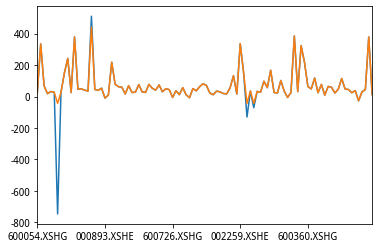

In [19]:
fund['pe_ratio'].iloc[0,:100].plot()
fund['pe_ratio_winsorize'].iloc[0,:100].plot()

In [20]:
#二、实现中位数绝对偏差去极值
#1、找出因子的中位数median
#2、得到每个因子值与中位数的绝对偏差值｜x-median｜
#3、得到绝对偏差值的中位数，MAD,median(|x-median|)
#4、计算MAD_e = 1.4826*MAD,然后确定参数n,做出调整

def mad(factor):
    #1、
    me = np.median(factor)
    
    #2、3、
    mad = np.median(abs(factor - me))
    
    up = me + (3 * 1.4826 * mad)
    down = me - (3 * 1.4826 * mad)
    
    #利用3倍中位数的值去极值
    factor = np.where(factor > up,up,factor)
    factor = np.where(factor < down,down,factor)
    
    return factor

In [21]:

fund['pe_ratio_3mad'] = mad(fund['pe_ratio'])

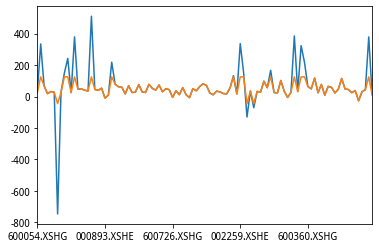

In [22]:
fund['pe_ratio'].iloc[0,:100].plot()
fund['pe_ratio_3mad'].iloc[0,:100].plot()

In [50]:
#3、3sigma标准差去极值的方法
def threesigma(factor):
    #计算平均值和标准差
    mean = factor.mean()
    
    std = factor.std()
    print(std)
    
    #计算上下限的数据
    up = mean + 3*std
    down = mean - 3*std
   
    
    #替换极值
    factor = np.where(factor>up,up,factor)
    print((factor<down).shape)
    factor = np.where(factor<down,down,factor)
    
    return factor


In [51]:
aa = fund['pe_ratio'].values
fund['pe_ratio_3sigma'] = threesigma(aa)


205.15385142242005
(1, 3469)


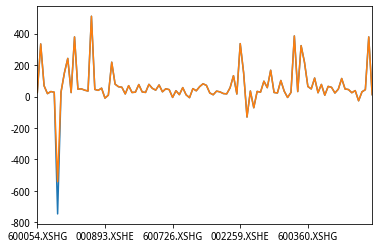

In [54]:
fund['pe_ratio'].iloc[0,:100].plot()
fund['pe_ratio_3sigma'].iloc[0,:100].plot()

In [55]:
#二、标准化处理
from sklearn.preprocessing import StandardScaler

In [56]:
std = StandardScaler()
print(fund['pe_ratio_3mad'])
std.fit_transform(fund['pe_ratio_3mad'].dropna())

           600054.XSHG 600316.XSHG 000570.XSHE 000892.XSHE 000715.XSHE  \
2018-01-02     25.9351     124.887       68.19     18.2915     31.6029   

           002099.XSHE 600685.XSHG 002441.XSHE 002197.XSHE 300101.XSHE  ...  \
2018-01-02     27.1992    -45.6799     27.2347     124.887     124.887  ...   

           002416.XSHE 002183.XSHE 002182.XSHE 002075.XSHE 603042.XSHG  \
2018-01-02     25.8615     25.7119     39.8738     50.4726     55.3581   

           002184.XSHE 002074.XSHE 600977.XSHG 002893.XSHE 001872.XSHE  
2018-01-02     124.887     29.9623     30.1534     64.0988      6.5806  

[1 rows x 3469 columns]


array([[0., 0., 0., ..., 0., 0., 0.]])

In [57]:
#自己实现标准化
def stand(factor):
    mean = factor.mean()
    std = factor.std()
    
    return (factor - mean)/std

In [59]:
print(stand(fund['pe_ratio'].values))
fund['pe_ration_stand'] = stand(fund['pe_ratio'].values)


[[-0.23434050621390184 1.2673349332866815 -0.028373619864810323 ...
  -0.21377886444723398 -0.04831572658927076 -0.32868189861675906]]


In [65]:
from sklearn.linear_model import LinearRegression

#三、数据中性化
#获得两个因子的数据
q = query(fundamentals.eod_derivative_indicator.pb_ratio,
    fundamentals.eod_derivative_indicator.market_cap)
    
#获取的是某一天的横截面数据
factor = get_fundamentals(q,entry_date='2018-01-03').major_xs('2018-01-03 00:00:00')

#factor是一个DataFrame
#print(type(factor))

#先对pb_ratio进行去极值标准化处理
factor['pb_ratio'] = mad(factor['pb_ratio'].values)
factor['pb_ratio'] = stand(factor['pb_ratio'].values)

#确定回归的数据
#x：市值
#y:因子数据
x = factor['market_cap'].values.reshape(-1,1)

y = factor['pb_ratio'].values

#建立回归方程并预测
lr = LinearRegression()
lr.fit(x,y)
y_predict = lr.predict(x)

#去除线性的关系，留下误差作为该因子的值
factor['pb_ratio_middle'] = y-y_predict

factor

/usr/local/lib/python3.6/site-packages/rqdatac/services/financial.py:339: UserWarning: Panel will be deprecated. Please use 'expect_df=True' to get a MultiIndex DataFrame.
  warnings.warn("Panel will be deprecated. Please use 'expect_df=True' to get a MultiIndex DataFrame.")


,pb_ratio,market_cap,pb_ratio_middle
600073.XSHG,-0.740255,7.7644e+09,-0.749067
000612.XSHE,-0.661729,1.10994e+10,-0.667813
600033.XSHG,-1.21741,1.00994e+10,-1.22431
000017.XSHE,2.33605,3.47901e+09,2.32373
600470.XSHG,-1.07436,3.04614e+09,-1.08703
600865.XSHG,-0.928939,3.01368e+09,-0.941639
002402.XSHE,1.0341,7.92596e+09,1.02542
002368.XSHE,0.131386,1.06382e+10,0.124925
002602.XSHE,1.43175,3.46233e+10,1.44492
601908.XSHG,-0.981599,1.09542e+10,-0.987802
